# Credit Fraud Detector

## Load Dependencies

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

import warnings
warnings.filterwarnings('ignore')

## Load Data

From the dataset description:

| Feature|  Description|
|--:|:--|
Time | Number of seconds elapsed between this transaction and the first transaction in the dataset | 
V1 - V28 | may be result of a PCA Dimensionality reduction to protect user identities and sensitive features | 
Amount | Transaction amount | 
Class | 1 for fraudulent transactions, 0 otherwise | 

In [2]:
dataset = pd.read_csv("creditcard.csv")
dataset

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [3]:
print("Dataset has ",dataset.shape[0], "rows and ", dataset.shape[1], "columns")

Dataset has  284807 rows and  31 columns


The robust scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

source: <https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html>

In [4]:
rob_scaler = RobustScaler()

dataset['scaled_amount'] = rob_scaler.fit_transform(dataset['Amount'].values.reshape(-1,1))
dataset['scaled_time'] = rob_scaler.fit_transform(dataset['Time'].values.reshape(-1,1))

dataset.drop(['Time','Amount'], axis=1, inplace=True)

Target 

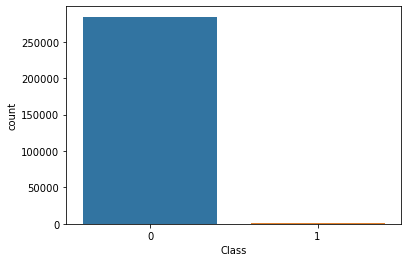

In [5]:
sns.countplot('Class', data=dataset)

In [6]:
print('Distribution of the Classes in the subsample dataset')
print(round(dataset['Class'].value_counts()/len(dataset) * 100, 4))

Distribution of the Classes in the subsample dataset
0    99.8273
1     0.1727
Name: Class, dtype: float64


Very unbalanced

# Modeling

In [7]:
X = dataset.drop('Class', axis=1)
y = dataset['Class']

In [8]:
# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test  = X_test.values
y_train = y_train.values
y_test  = y_test.values

## Linear Models

Fit 3 models using cross validation:

* Multiple linear regression model
* Weighted Multiple linear regression model (weights inversely proportional to class frequencies)
* Weighted Lasso multiple linear regression model

The metrics used are average precision (AP) (AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight)

In [10]:
classifiers = {
    "LogisticRegression": LogisticRegression(penalty="none", class_weight=None, random_state = 42, n_jobs = -1, verbose = 0),
    "LogisticRegressionWtd": LogisticRegression(penalty="none", class_weight="balanced", random_state = 42, n_jobs = -1, verbose = 0),
    "LogisticRegressionLasso": LogisticRegression(penalty="l1", solver = "saga", class_weight="balanced", random_state = 42, n_jobs = -1, verbose = 0)
}

In [11]:
#for key, classifier in classifiers.items():
#    classifier.fit(X_train, y_train)
#    training_score = cross_val_score(classifier, X_train, y_train, cv=5, scoring= "average_precision")
#    print("Classifiers: ", key, "Has a training score of", round(training_score.mean(), 4) * 100, "% AP score")

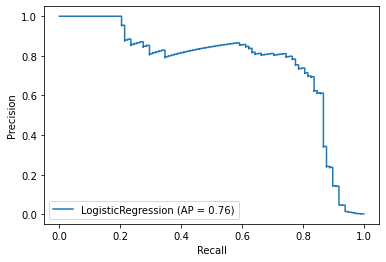

In [12]:
model = classifiers["LogisticRegression"] 
model.fit(X_train, y_train)

disp = plot_precision_recall_curve(model, X_test, y_test)

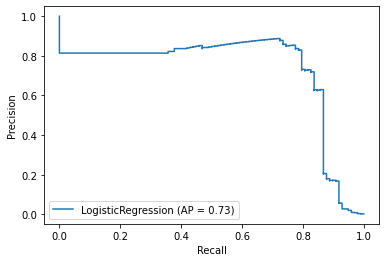

In [13]:
model = classifiers["LogisticRegressionWtd"] 
model.fit(X_train, y_train)

disp = plot_precision_recall_curve(model, X_test, y_test)

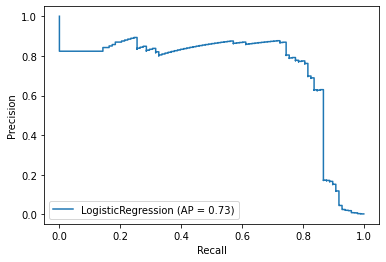

In [14]:
model = classifiers["LogisticRegressionLasso"] 
model.fit(X_train, y_train)

disp = plot_precision_recall_curve(model, X_test, y_test)

GridSearch to Elastic net 

## Grid Search pipeline

Lets define the pipeline

In [15]:
def search_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='f1',
                       do_probabilities = False, search_mode = 'GridSearchCV', n_iterations = 0):
    fitted_model = None
    
    if(search_mode == 'GridSearchCV'):
        gs = GridSearchCV(
            estimator=model,
            param_grid=param_grid, 
            cv=cv, 
            n_jobs=-1, 
            scoring=scoring_fit,
            verbose=2
        )
        fitted_model = gs.fit(X_train_data, y_train_data)

    elif (search_mode == 'RandomizedSearchCV'):
        rs = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid, 
            cv=cv,
            n_iter=n_iterations,
            n_jobs=-1, 
            scoring=scoring_fit,
            verbose=2
        )
        fitted_model = rs.fit(X_train_data, y_train_data)
    
    
    if(fitted_model != None):
        if do_probabilities:
            pred = fitted_model.predict_proba(X_test_data)
        else:
            pred = fitted_model.predict(X_test_data)
            
        return fitted_model, pred

In [16]:
model = LogisticRegression(class_weight="balanced", random_state = 42)
param_grid = {'l1_ratio': np.linspace(0, 1, 30)}

model_fitted, model_pred = search_pipeline(X_train, X_test, y_train, y_test, model, param_grid, cv=5, scoring_fit='average_precision',
                       do_probabilities = False, search_mode = 'RandomizedSearchCV', n_iterations = 150)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.7min finished


In [17]:
best_model_fitted = model_fitted.best_estimator_

Logistic Regression Cross Validation AP Score:  75.352%


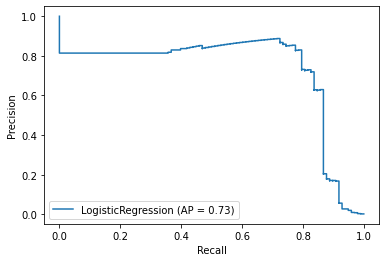

In [21]:
disp = plot_precision_recall_curve(best_model_fitted, X_test, y_test)

In [28]:
model = RandomForestClassifier(class_weight = "balanced", random_state = 42)


n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 100)] # Number of trees in random forest
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4] # Minimum number of samples required at each leaf node
bootstrap = [True, False] # Method of selecting samples for training each tree


param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


model_fitted, model_pred = search_pipeline(X_train, X_test, y_train, y_test, model, param_grid, cv=5, scoring_fit='average_precision',
                       do_probabilities = False, search_mode = 'RandomizedSearchCV', n_iterations = 20)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 251.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 752.6min finished


In [31]:
best_model_fitted = model_fitted.best_estimator_
best_model_fitted

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=80,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=618, random_state=42)

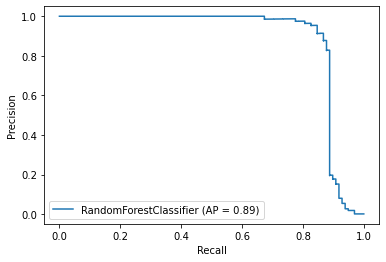

In [32]:
disp = plot_precision_recall_curve(best_model_fitted, X_test, y_test)